In [1]:
import os
from imps import *

In [ ]:
# changes when running on the cluster
acdc_data = "/nfs/"+acdc_data[8:] 

acdc_data_train = acdc_data + '/train'
acdc_data_test = acdc_data + '/test'
acdc_data_validation = acdc_data + '/validation'

In [6]:
def sep_gen(data, ismask, seed=seed, batch_size=15, dset="training"):
    if dset=="training":
        if ismask:
            datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20,
                width_shift_range=.2,
                height_shift_range=.2,
                horizontal_flip=True,
                vertical_flip=True, 
                preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype),
                )
        else:
            datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20,
                width_shift_range=.2,
                height_shift_range=.2,
                horizontal_flip=True,
                vertical_flip=True,     
                )
    elif dset=="validation":
        if ismask:
            datagen = tf.keras.preprocessing.image.ImageDataGenerator(
               preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype),
                )
            
        else:
            datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    else:
        raise ValueError( "The argument \"dset\" can either be \"training\" or \"validation\".")
    
    return datagen.flow(data, batch_size=batch_size, seed=seed)

In [68]:
# %% Get data ACDC


# training
acdc_data, train_afn, train_hdr = get_acdc(acdc_data_train)
X_train, y_train, info_train = acdc_data[0], acdc_data[1], acdc_data[2]
# validation
acdc_data, val_afn, val_hdr = get_acdc(acdc_data_validation)
X_val, y_val, info_val = acdc_data[0], acdc_data[1], acdc_data[2]
# testing
acdc_data, test_afn, test_hdr = get_acdc(acdc_data_test)
X_test, y_test, info_test = acdc_data[0], acdc_data[1], acdc_data[2]

y_train_cat = convert_masks(y_train)
y_val_cat = convert_masks(y_val)
y_test_cat = convert_masks(y_test)

batch_size = 10

train_generator=unite_gen(X_train, y_train_cat[:,::4,::4,:], y_train_cat[:,::2,::2,:], y_train_cat, batch_size, "training")
val_generator=unite_gen(X_val, y_val_cat[:,::4,::4,:], y_val_cat[:,::2,::2,:], y_val_cat, batch_size, "validation")


In [70]:
def myunet(data):
    
    training = True # flag

    att_heads = [2, 2, 2, 2, 2, 2, 2, 2, 2]
    filters = [32, 64, 128, 256, 512, 256, 128, 64, 32]
    #
    blocks = len(filters)

    stochastic_depth_rate = 0.0
    
    image_size = data.shape[1]
    
    input_shape = (data.shape[1], data.shape[2], data.shape[3])
    

    
    class StochasticDepth(layers.Layer):
        def __init__(self, drop_prop, **kwargs):
            super(StochasticDepth, self).__init__(**kwargs)
            self.drop_prob = drop_prop
    
        def call(self, x, training=training):
            if training:
                keep_prob = 1 - self.drop_prob
                shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
                random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
                random_tensor = tf.floor(random_tensor)
                return (x / keep_prob) * random_tensor
            return x
    
    def mlp(x, hidden_units, dropout_rate): 
        x1 = layers.Conv2D(units, 3, padding='same', activation=tf.nn.gelu)(x)
        x1 = layers.Dropout(0.1)(x1)
        x2 = layers.Conv2D(units, 3, padding='same', dilation_rate=2, activation=tf.nn.gelu)(x)
        x2 = layers.Dropout(0.1)(x2)
        x3 = layers.Conv2D(units, 3, padding='same', dilation_rate=3, activation=tf.nn.gelu)(x)
        x3 = layers.Dropout(0.1)(x3)
        added = layers.Add()([x1,x2, x3])
        x_out = layers.Conv2D(units, 3, padding='same', activation=tf.nn.gelu)(added)
        x_out = layers.Dropout(0.1)(x_out)
        return x_out

    from tensorflow.keras.layers import Layer, Dense, Conv2D, Dropout, MultiHeadAttention, BatchNormalization, \
    DepthwiseConv2D, UpSampling2D
    from tensorflow.keras.models import Sequential
    from tensorflow import Tensor, divide, concat, random, split, reshape, transpose, float32
    from typing import List, Union, Iterable
    
        
    class Attention(Layer):
        def __init__(self,
                      # dim_in,
                      dim_out,
                      num_heads,
                      proj_drop=0.0,#2,
                      kernel_size=3,
                      stride_kv=1, 
                      stride_q=1, 
                      padding_kv="same",
                      padding_q="same",
                      attention_bias=True):
            super().__init__()
            self.stride_kv = stride_kv
            self.stride_q = stride_q
            self.dim = dim_out
            self.num_heads = num_heads
            self.scale = dim_out ** -0.5
    
            self.conv_proj_q = self._build_projection(kernel_size, stride_q, padding_q)
            self.conv_proj_k = self._build_projection(kernel_size, stride_kv, padding_kv)
            self.conv_proj_v = self._build_projection(kernel_size, stride_kv, padding_kv)
    
            self.attention = MultiHeadAttention(self.num_heads, dim_out, use_bias=attention_bias)
            self.proj_drop = Dropout(proj_drop)
            
    
        @staticmethod
        def _build_projection(kernel_size, stride, padding):
            proj = Sequential([DepthwiseConv2D(kernel_size, padding=padding, strides=stride, use_bias=False),
                layers.LayerNormalization(),                
            ])
            return proj
     
    
        def call_conv(self, x, h, w):
            q = self.conv_proj_q(x)
            k = self.conv_proj_k(x)
            v = self.conv_proj_v(x)
            return q, k, v
    
        def call(self, inputs, mask=None, training=training, h=1, w=1):
            x = inputs
            q, k, v = self.call_conv(x, h, w)
            x = self.attention(q, v, key=k)
            if training:
                x = self.proj_drop(x)            
            return x
 
    
    def att(x_in, 
            num_heads,
            dpr, 
            proj_drop=0.0,
            attention_bias=True,
            padding_q="same",
            padding_kv="same",
            stride_kv=2,
            stride_q=1):
    
        b, h, w, c = x_in.shape
    
        attention_output = Attention(#dim_in=c,
                                      dim_out=c,
                                      num_heads=num_heads,
                                      proj_drop=proj_drop,
                                      attention_bias=attention_bias, 
                                      padding_q=padding_q, 
                                      padding_kv=padding_kv, 
                                      stride_kv=stride_kv, 
                                      stride_q=stride_q, 
                                      )(x_in, h=h, w=w, training=training, mask=None)
        
        
        # Skip connection 1.
        attention_output = StochasticDepth(dpr)(attention_output)
        attention_output = Conv2D(x_in.shape[-1], 3, 1, padding="same", activation="relu")(attention_output)
        x2 = layers.Add()([attention_output, x_in]) 
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        x3 = mlp(x3, hidden_units=[c,c], dropout_rate=0.0)
        # Skip connection 2.
        x3 = StochasticDepth(dpr)(x3)
        encoded_patches = layers.Add()([x3, x2])
        
        return encoded_patches
    
    def create_model(
        image_size=image_size,
        input_shape=input_shape,
    ):
    
        inputs = layers.Input(input_shape)
    
        dpr = [x for x in np.linspace(0, stochastic_depth_rate, blocks)]
    
        initializer = 'he_normal'
        drp_out = 0.3
        act = "relu"    
    
        scale_img_2 = layers.AveragePooling2D(2,2)(inputs)
        scale_img_3 = layers.AveragePooling2D(2,2)(scale_img_2)
        scale_img_4 = layers.AveragePooling2D(2,2)(scale_img_3)
       
       
        # first block
        x1 = layers.LayerNormalization(epsilon=1e-5)(inputs[:,:,:,-1])
        x11 = tf.expand_dims(x1, -1)                                
        x11 = Conv2D(filters[0], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Conv2D(filters[0], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Dropout(drp_out)(x11)
        x11 = MaxPooling2D((2,2))(x11)
        out = att(x11, att_heads[0], dpr[0])
        skip1=out
        #print("\nBlock 1 -> input:", x1.shape, "output:", skip1.shape)
        
        # second block
        x1 = layers.LayerNormalization(epsilon=1e-5)(out)
        x11=x1
        x11 = concatenate([Conv2D(filters[0], 3, padding="same", activation=act)(scale_img_2), x11], axis=3)
        x11 = Conv2D(filters[1], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Conv2D(filters[1], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Dropout(drp_out)(x11)
        x11 = MaxPooling2D((2,2))(x11)
        out = att(x11, att_heads[1], dpr[1])
        skip2=out
        #print("Block 2 -> input:", x1.shape, "output:", skip2.shape)
        
        # third block
        x1 = layers.LayerNormalization(epsilon=1e-5)(out)
        x11=x1
        x11 = concatenate([Conv2D(filters[1], 3, padding="same", activation=act)(scale_img_3), x11], axis=3)
        x11 = Conv2D(filters[2], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Conv2D(filters[2], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Dropout(drp_out)(x11)
        x11 = MaxPooling2D((2,2))(x11)
        out = att(x11, att_heads[2], dpr[2])
        skip3=out
        #print("Block 3 -> input:", x1.shape, "output:", skip3.shape)
        
        # fourth block
        x1 = layers.LayerNormalization(epsilon=1e-5)(out)
        x11=x1
        x11 = concatenate([Conv2D(filters[2], 3, padding="same", activation=act)(scale_img_4), x11], axis=3)
        x11 = Conv2D(filters[3], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Conv2D(filters[3], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Dropout(drp_out)(x11)
        x11 = MaxPooling2D((2,2))(x11)
        out = att(x11, att_heads[3], dpr[3])
        skip4 = out
        #print("Block 4 -> input:", x1.shape, "output:", skip4.shape)
         
        # fifth block
        x1 = layers.LayerNormalization(epsilon=1e-5)(out)
        x11=x1
        x11 = Conv2D(filters[4], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Conv2D(filters[4], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Dropout(drp_out)(x11)
        x11 = MaxPooling2D((2,2))(x11)
        out = att(x11, att_heads[4], dpr[4])
        # print("Block 5 -> input:", x1.shape, "output:", tf.reshape(out, (tf.shape(out)[0], np.sqrt(out.get_shape()[1]), np.sqrt(out.get_shape()[1]), out.get_shape()[2])).shape) 
        
        # sixth block
        x1 = layers.LayerNormalization(epsilon=1e-5)(out)
        x11=x1
        x11 = Conv2D(filters[5], 2, padding="same", activation=act, kernel_initializer=initializer)(UpSampling2D(size=(2,2))(x11))
        x11 = concatenate([skip4,x11], axis=3)
        x11 = Conv2D(filters[5], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Conv2D(filters[5], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Dropout(drp_out)(x11)
        out = att(x11, att_heads[5], dpr[5])
        # print("Block 6 -> input:", x1.shape, "output:", tf.reshape(out, (tf.shape(out)[0], np.sqrt(out.get_shape()[1]), np.sqrt(out.get_shape()[1]), out.get_shape()[2])).shape)                 
        
        # seventh block
        x1 = layers.LayerNormalization(epsilon=1e-5)(out)
        x11=x1
        x11 = Conv2D(filters[6], 2, padding="same", activation=act, kernel_initializer=initializer)(UpSampling2D(size=(2,2))(x11))
        x11 = concatenate([skip3,x11], axis=3)
        x11 = Conv2D(filters[6], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Conv2D(filters[6], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Dropout(drp_out)(x11)
        out = att(x11, att_heads[6], dpr[6])
        skip7=out
        # print("Block 7 -> input:", x1.shape, "output:", skip7.shape)  
        
        # eighth block
        x1 = layers.LayerNormalization(epsilon=1e-5)(out)
        x11=x1
        x11 = Conv2D(filters[7], 2, padding="same", activation=act, kernel_initializer=initializer)(UpSampling2D(size=(2,2))(x11))
        x11 = concatenate([skip2, x11], axis=3)
        x11 = Conv2D(filters[7], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Conv2D(filters[7], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Dropout(drp_out)(x11)
        out = att(x11, att_heads[7], dpr[7])
        skip8=out
        #print("Block 8 -> input:", x1.shape, "output:", skip8.shape) 
        
        # nineth block
        x1 = layers.LayerNormalization(epsilon=1e-5)(out)
        x11=x1
        x11 = Conv2D(filters[8], 2, padding="same", activation=act, kernel_initializer=initializer)(UpSampling2D(size=(2,2))(x11))
        x11 = concatenate([skip1, x11], axis=3)
        x11 = Conv2D(filters[8], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Conv2D(filters[8], 3, 1, padding="same", activation=act, kernel_initializer=initializer)(x11)
        x11 = Dropout(drp_out)(x11)
        out = att(x11, att_heads[8], dpr[8])
        skip9=out
        print("Block 9 -> input:", x1.shape, "output:", skip9.shape) 


        skip7 = layers.LayerNormalization(epsilon=1e-5)(UpSampling2D(size=(2,2))(skip7))
        out7 = Conv2D(filters[6], 3, padding="same", activation=act, kernel_initializer=initializer)(skip7)
        out7 = Conv2D(filters[6], 3, padding="same", activation=act, kernel_initializer=initializer)(out7)
        #
        skip8 = layers.LayerNormalization(epsilon=1e-5)(UpSampling2D(size=(2,2))(skip8))
        out8 = Conv2D(filters[7], 3, padding="same", activation=act, kernel_initializer=initializer)(skip8)
        out8 = Conv2D(filters[7], 3, padding="same", activation=act, kernel_initializer=initializer)(out8)
        #
        skip9 = layers.LayerNormalization(epsilon=1e-5)(UpSampling2D(size=(2,2))(skip9))
        out9 = Conv2D(filters[8], 3, padding="same", activation=act, kernel_initializer=initializer)(skip9)
        out9 = Conv2D(filters[8], 3, padding="same", activation=act, kernel_initializer=initializer)(out9)
        #

        # # ACDC
        out7 = Conv2D(4, (1,1), activation="sigmoid", name='pred1')(out7)
        out8 = Conv2D(4, (1,1), activation="sigmoid", name='pred2')(out8)
        out9 = Conv2D(4, (1,1), activation="sigmoid", name='final')(out9)

        
        print("\n")
        print("DS 1 -> input:", skip7.shape, "output:", out7.shape) 
        print("DS 2 -> input:", skip8.shape, "output:", out8.shape) 
        print("DS 3 -> input:", skip9.shape, "output:", out9.shape) 
        


        model = keras.Model(inputs=inputs, outputs=[out7, out8, out9])

        
        return model    
    return create_model()


In [72]:
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import tensorflow as tf 

epsilon = 1e-5
smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    loss = (2/10)*binary_crossentropy(y_true, y_pred) + (1/3)*dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [73]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    model = myunet(X_train)

    name = "myUNet".format(time.strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard("myunet_tflogs/{}".format(name))

    warmup_epoch = 8
    warmup_run_epochs = 120
    normal_run_epochs = 30

    rlrop = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        mode='min', 
        patience=5,
        factor=.5, 
        # min_lr=1e-6, 
        min_delta=.001,
        verbose=1)

    checkpoint_filepath = os.getcwd()+"/acdc_myunet_weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True
        )

    earlystop = keras.callbacks.EarlyStopping(
                monitor="val_loss",
                restore_best_weights=True,
                min_delta=.001,
                patience=12)

    lr = 1e-3
    opt = tf.keras.optimizers.Adam(lr = lr)

    # Compute the number of warmup batches
    warmup_batches = warmup_epoch * len(X_train)//batch_size
    # Create the Learning rate scheduler
    warm_up_lr = WarmUpLearningRateScheduler(warmup_batches, init_lr=lr)
    
    loss = {'pred1':bce_dice_loss,
            'pred2':bce_dice_loss,
            'final':bce_dice_loss}

    loss_weights = {'pred1':.14,
                    'pred2':.29,
                    'final':.57}   



    loss1 = "binary_crossentropy"

    model.compile(optimizer = opt, 
                  loss = [loss1, loss1, loss1],
                  loss_weights=[.14, .29, .57],
                  #metrics = [dsc]
                 )  



history = model.fit(
    train_generator,
    steps_per_epoch = len(X_train)//batch_size, 
    epochs=warmup_run_epochs,
    callbacks=[warm_up_lr],
)


np.save('acdc_history_warmup_bestmodel.npy',history.history)

history = model.fit(
    train_generator,
    validation_data = val_generator,
    steps_per_epoch = len(X_train)//batch_size,
    validation_steps = len(X_val)//batch_size,
    epochs=normal_run_epochs,
    callbacks = [rlrop, checkpoint_callback, tensorboard_callback],
    
          )

np.save('acdc_history_rlrop_bestmodel.npy',history.history)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Block 1 -> input: (None, 224, 224) output: (None, 112, 112, 32)
Block 2 -> input: (None, 112, 112, 32) output: (None, 56, 56, 64)
Block 3 -> input: (None, 56, 56, 64) output: (None, 28, 28, 128)
Block 4 -> input: (None, 28, 28, 128) output: (None, 14, 14, 256)
Block 7 -> input: (None, 14, 14, 256) output: (None, 28, 28, 128)
Block 8 -> input: (None, 28, 28, 128) output: (None, 56, 56, 64)
Block 9 -> input: (None, 56, 56, 64) output: (None, 112, 112, 32)


DS 1 -> input: (None, 56, 56, 128) output: (None, 56, 56, 4)
DS 2 -> input: (None, 112, 112, 64) output: (None, 112, 112, 4)
DS 3 -> input: (None, 224, 224, 32) output: (None, 224, 224, 4)
Epoch 1/120
134/134 [==============================] - 84s 500ms/step - loss: 0.3282 - pred1_loss: 0.1721 - pred2_loss: 0.2156 - final_loss: 0.4237
Epoch 2/120
134/134 [==============================] - 67s 500ms/step - loss: 0.0834 - pred1_loss: 0

134/134 [==============================] - 67s 500ms/step - loss: 0.0104 - pred1_loss: 0.0218 - pred2_loss: 0.0106 - final_loss: 0.0074
Epoch 51/120
134/134 [==============================] - 67s 499ms/step - loss: 0.0116 - pred1_loss: 0.0235 - pred2_loss: 0.0118 - final_loss: 0.0086
Epoch 52/120
134/134 [==============================] - 67s 499ms/step - loss: 0.0110 - pred1_loss: 0.0226 - pred2_loss: 0.0112 - final_loss: 0.0081
Epoch 53/120
134/134 [==============================] - 67s 499ms/step - loss: 0.0101 - pred1_loss: 0.0214 - pred2_loss: 0.0104 - final_loss: 0.0072
Epoch 54/120
134/134 [==============================] - 67s 500ms/step - loss: 0.0099 - pred1_loss: 0.0214 - pred2_loss: 0.0103 - final_loss: 0.0070
Epoch 55/120
134/134 [==============================] - 67s 500ms/step - loss: 0.0102 - pred1_loss: 0.0215 - pred2_loss: 0.0105 - final_loss: 0.0072
Epoch 56/120
134/134 [==============================] - 67s 500ms/step - loss: 0.0100 - pred1_loss: 0.0213 - pred2_loss

134/134 [==============================] - 67s 499ms/step - loss: 0.0090 - pred1_loss: 0.0196 - pred2_loss: 0.0094 - final_loss: 0.0061
Epoch 106/120
134/134 [==============================] - 67s 499ms/step - loss: 0.0088 - pred1_loss: 0.0197 - pred2_loss: 0.0092 - final_loss: 0.0060
Epoch 107/120
134/134 [==============================] - 67s 499ms/step - loss: 0.0095 - pred1_loss: 0.0206 - pred2_loss: 0.0100 - final_loss: 0.0066
Epoch 108/120
134/134 [==============================] - 67s 499ms/step - loss: 0.0094 - pred1_loss: 0.0205 - pred2_loss: 0.0099 - final_loss: 0.0064
Epoch 109/120
134/134 [==============================] - 67s 499ms/step - loss: 0.0092 - pred1_loss: 0.0204 - pred2_loss: 0.0096 - final_loss: 0.0062
Epoch 110/120
134/134 [==============================] - 67s 499ms/step - loss: 0.0089 - pred1_loss: 0.0198 - pred2_loss: 0.0094 - final_loss: 0.0060
Epoch 111/120
134/134 [==============================] - 67s 500ms/step - loss: 0.0094 - pred1_loss: 0.0206 - pred

134/134 [==============================] - 70s 520ms/step - loss: 0.0078 - pred1_loss: 0.0182 - pred2_loss: 0.0083 - final_loss: 0.0049 - val_loss: 0.0104 - val_pred1_loss: 0.0217 - val_pred2_loss: 0.0114 - val_final_loss: 0.0071
Epoch 24/30
134/134 [==============================] - 70s 520ms/step - loss: 0.0079 - pred1_loss: 0.0186 - pred2_loss: 0.0084 - final_loss: 0.0050 - val_loss: 0.0100 - val_pred1_loss: 0.0207 - val_pred2_loss: 0.0110 - val_final_loss: 0.0069
Epoch 25/30
134/134 [==============================] - 70s 519ms/step - loss: 0.0076 - pred1_loss: 0.0182 - pred2_loss: 0.0082 - final_loss: 0.0048 - val_loss: 0.0099 - val_pred1_loss: 0.0200 - val_pred2_loss: 0.0110 - val_final_loss: 0.0070
Epoch 26/30
134/134 [==============================] - 70s 520ms/step - loss: 0.0078 - pred1_loss: 0.0184 - pred2_loss: 0.0083 - final_loss: 0.0049 - val_loss: 0.0100 - val_pred1_loss: 0.0204 - val_pred2_loss: 0.0110 - val_final_loss: 0.0069

Epoch 00026: ReduceLROnPlateau reducing lea

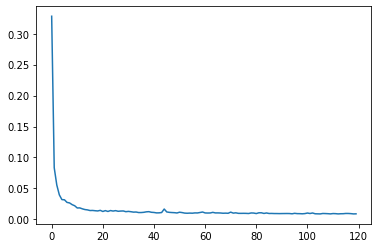

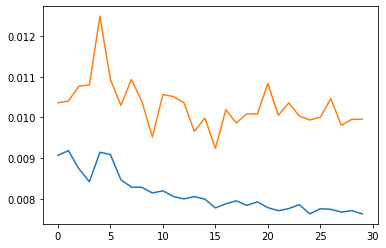

In [74]:
history=np.load("acdc_history_warmup_bestmodel.npy",allow_pickle='TRUE').item()
plt.plot(history["loss"])
plt.show()
history=np.load("acdc_history_rlrop_bestmodel.npy",allow_pickle='TRUE').item()
plt.plot(history["loss"])
plt.plot(history["val_loss"])

In [76]:
predicted = model.predict(X_test, batch_size=1)

print(np.round(np.array(metrics(y_test[:,:,:,-1], np.argmax(predicted[2], axis=3),0)),4))
print(np.round(np.array(metrics(y_test[:,:,:,-1], np.argmax(predicted[2], axis=3),0)).mean(),4))

[0.9589 0.9202 0.906 ]
0.9284
